In [1]:
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats

# 1) Loading Data

In [2]:
dataPath = 'Data/2016-2019(NO2, NOX, PM2.5)'
listOfDataFrames=[]
stations=os.listdir(dataPath)
for station in stations:
    print("Processing year: "+ dataPath +" station: "+station)
    airQualityData=pd.read_csv(dataPath+'\\'+station, header=12,sep=';').rename(columns={'Start':'Start','Slut':'Stop'})
    airQualityData.rename(columns = lambda x: re.sub('NOX.*','NOX',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('PM10.*','PM10',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('PM2.5.*','PM2_5',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('NO2.*','NO2',x), inplace = True)
    listOfDataFrames.append(airQualityData)
airQualityData= pd.DataFrame(columns= [])
for airData in listOfDataFrames:
    airQualityData=airQualityData.append(airData)
    
airQualityData['Start'] = pd.to_datetime(airQualityData['Start'])
print(airQualityData.head(5))
print(airQualityData.shape)

Processing year: Data/2016-2019(NO2, NOX, PM2.5) station: shair-18644-1-6-3.csv
Processing year: Data/2016-2019(NO2, NOX, PM2.5) station: shair-8779-1-6-3.csv
Processing year: Data/2016-2019(NO2, NOX, PM2.5) station: shair-8780-1-6-3.csv
Processing year: Data/2016-2019(NO2, NOX, PM2.5) station: shair-8781-1-6-1.csv
                Start              Stop   NO2   NOX  PM10  PM2_5
0 2016-01-01 00:00:00  2016-01-01 01:00  30.4  53.7  44.2   25.3
1 2016-01-01 01:00:00  2016-01-01 02:00  36.1  68.4  17.5    7.8
2 2016-01-01 02:00:00  2016-01-01 03:00  38.8  67.5  15.4    9.2
3 2016-01-01 03:00:00  2016-01-01 04:00  25.9  46.4  13.1    6.6
4 2016-01-01 04:00:00  2016-01-01 05:00  20.2  36.3  14.2    9.3
(140256, 6)


# 2) Visualizing Data

#### 1-View percentage of available data


<AxesSubplot:>

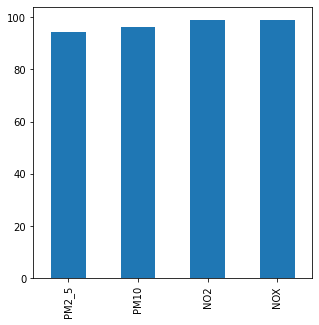

In [3]:
total = airQualityData.isnull().sum().sort_values(ascending = False)
total = total[airQualityData.isnull().sum().sort_values(ascending = False) != 0]
percent =  100 - total / len(airQualityData) * 100
percent[airQualityData.isnull().sum().sort_values(ascending = False) != 0].plot.bar(figsize = (5,5))

#### 2-Viewing subset of data

<AxesSubplot:xlabel='Start', ylabel='PM10'>

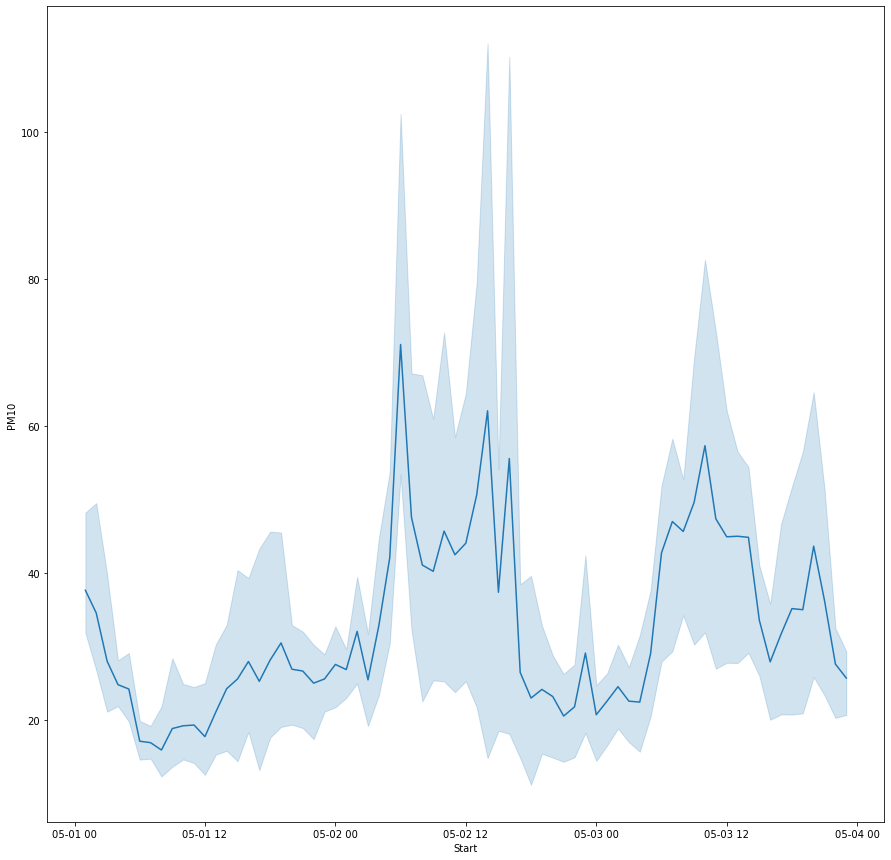

In [4]:
subsetData = airQualityData[(airQualityData['Start'] >"2016-05-01 00:00:00") & (airQualityData['Start'] < "2016-05-04 00:00:00")]
fig , ax =  plt.subplots(figsize=(15,15))
sns.lineplot(data=subsetData,x="Start",y="PM10",ax=ax)

#### 3- Histogram

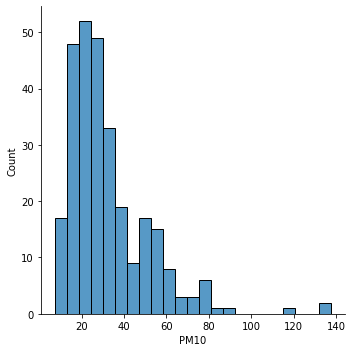

In [5]:
sns.displot(subsetData, x="PM10")

# 3) Pre-processing

In [120]:
processedAQD=airQualityData

#### 1- Replacing negative values with NaN

In [121]:
processedAQD.loc[airQualityData['PM10'] <= 0, 'PM10']=np.nan
processedAQD.loc[airQualityData['PM2_5'] <= 0, 'PM2_5']=np.nan
processedAQD.loc[airQualityData['NOX'] <= 0, 'NOX']=np.nan
processedAQD.loc[airQualityData['NO2'] <= 0, 'NO2']=np.nan

#### 2- Dropping unnecessary columns

In [122]:
processedAQD=processedAQD.drop('Stop', axis = 1)

#### 3- Removing outliers (IQR)   WORK IN PROGRESS

In [9]:
processedAQD=processedAQD.set_index('Start')
Q1 = processedAQD.quantile(0.25)
Q3=  processedAQD.quantile(0.75)
IQR= Q3-Q1
print(IQR)
processedAQD = processedAQD[~((processedAQD < (Q1 - 1.5 * IQR)) |(processedAQD > (Q3 + 1.5 * IQR))).any(axis=1)]

NO2      29.9
NOX      65.9
PM10     14.7
PM2_5     4.9
dtype: float64


In [127]:
def outlier_remove(window_size = 6,x=None):
    for i in range(0,len(x),window_size):
        print(i)
        window=x[i : i+window_size]
        
        if(len(window)<window_size):
            continue
        print(window)
        average=np.mean(window)
        std=np.std(window)
        for i in range(len(window)):
            if (window[i] < average - 2 * std) or (window[i] > average + 2 * std): #anything not within sigma 2 of the standard deviation will be dropped-> check rule of 3 sigma
                window[i]=-1
        print(window)

In [126]:
outlier_remove(x=processedAQD['PM10'].values)

0
[ nan 17.5 15.4 13.1 14.2 13.7]
[ nan 17.5 15.4 13.1 14.2 13.7]
6
[15.4 14.2 14.2 14.5 45.6 79.9]
[15.4 14.2 14.2 14.5 45.6 79.9]
12
[104.2  70.5  79.5  64.6  59.4  51.8]
[104.2  70.5  79.5  64.6  59.4  51.8]
18
[60.9 44.1 38.9 27.7 32.5 33. ]
[60.9 44.1 38.9 27.7 32.5 33. ]
24
[ nan  7.4  9.4 10.1 10.   7.8]
[ nan  7.4  9.4 10.1 10.   7.8]
30
[ 12.9  22.5 145.8  77.7  67.9  13. ]
[ 12.9  22.5 145.8  77.7  67.9  13. ]
36
[ 15.2  24.4 118.5  79.4 105.2 121.4]
[ 15.2  24.4 118.5  79.4 105.2 121.4]
42
[ 96.1 101.7  73.4 123.   68.4   8.9]
[ 96.1 101.7  73.4 123.   68.4   8.9]
48
[6.1 6.2 4.9 5.7 8.6 8.5]
[6.1 6.2 4.9 5.7 8.6 8.5]
54
[ 11.   13.3  43.1  74.2 110.4 105.8]
[ 11.   13.3  43.1  74.2 110.4 105.8]
60
[110.6 113.1 112.1  67.2  63.6  52.3]
[110.6 113.1 112.1  67.2  63.6  52.3]
66
[44.8 37.4 42.7 45.6 40.5 37.8]
[44.8 37.4 42.7 45.6 40.5 37.8]
72
[63.9 46.8 51.  41.8 45.2  nan]
[63.9 46.8 51.  41.8 45.2  nan]
78
[ nan 80.9 58.4 58.7 59.4 40.1]
[ nan 80.9 58.4 58.7 59.4 40.1]
84
[

[ 6.   8.2 12.7 20.9 15.6 23.1]
[ 6.   8.2 12.7 20.9 15.6 23.1]
3396
[26.7 29.1 23.7 25.9 29.8  nan]
[26.7 29.1 23.7 25.9 29.8  nan]
3402
[31.4 35.  32.  34.1 33.1  nan]
[31.4 35.  32.  34.1 33.1  nan]
3408
[13.1 14.6 18.5 18.6 20.5 17. ]
[13.1 14.6 18.5 18.6 20.5 17. ]
3414
[13.1 18.8 23.1 23.2 25.1 32.4]
[13.1 18.8 23.1 23.2 25.1 32.4]
3420
[33.4 31.1 42.8 41.  29.1 31.3]
[33.4 31.1 42.8 41.  29.1 31.3]
3426
[44.  44.  33.7 33.8 26.8 25.8]
[44.  44.  33.7 33.8 26.8 25.8]
3432
[27.7 29.9 22.4 18.  26.7 37.1]
[27.7 29.9 22.4 18.  26.7 37.1]
3438
[35.1 50.4 48.5 71.1 77.9 76.2]
[35.1 50.4 48.5 71.1 77.9 76.2]
3444
[75.9 63.9 71.  41.9 46.3 70.3]
[75.9 63.9 71.  41.9 46.3 70.3]
3450
[56.3 56.7 45.4 39.5 31.3 37.5]
[56.3 56.7 45.4 39.5 31.3 37.5]
3456
[31.  33.4 32.4 29.8 33.2  nan]
[31.  33.4 32.4 29.8 33.2  nan]
3462
[37.4  nan 45.9 49.1 31.2 45.9]
[37.4  nan 45.9 49.1 31.2 45.9]
3468
[53.5 46.6 53.9 39.8 38.9 54.4]
[53.5 46.6 53.9 39.8 38.9 54.4]
3474
[33.5 32.7 34.4 26.  20.9 10.5]
[3

[18.4 17.7 16.1 17.1 15.1 14.5]
[18.4 17.7 16.1 17.1 15.1 14.5]
6666
[16.2 17.  13.3 10.7 12.3  9.7]
[16.2 17.  13.3 10.7 12.3  9.7]
6672
[7.5 6.  7.5 6.3 7.7 nan]
[7.5 6.  7.5 6.3 7.7 nan]
6678
[20.1 17.9 18.8 16.9 18.2 19.6]
[20.1 17.9 18.8 16.9 18.2 19.6]
6684
[22.5 24.8 20.4 19.  17.8 22.9]
[22.5 24.8 20.4 19.  17.8 22.9]
6690
[18.4 15.3 13.7 13.9 12.   7.7]
[18.4 15.3 13.7 13.9 12.   7.7]
6696
[6.4 6.1 7.6 8.3 9.8 nan]
[6.4 6.1 7.6 8.3 9.8 nan]
6702
[17.  17.5 18.7 16.  14.8 16.2]
[17.  17.5 18.7 16.  14.8 16.2]
6708
[15.6 12.8 18.9 12.7 15.1 18.7]
[15.6 12.8 18.9 12.7 15.1 18.7]
6714
[19.8 15.3 13.5 10.5 11.1  5.3]
[19.8 15.3 13.5 10.5 11.1  5.3]
6720
[4.2 1.7 1.6 3.8 4.9 nan]
[4.2 1.7 1.6 3.8 4.9 nan]
6726
[13.3 14.  17.3 18.5 22.  17.6]
[13.3 14.  17.3 18.5 22.  17.6]
6732
[16.  14.  10.9 12.9 12.8 12.8]
[16.  14.  10.9 12.9 12.8 12.8]
6738
[12.2 11.8  9.3  9.   8.1  7.4]
[12.2 11.8  9.3  9.   8.1  7.4]
6744
[8.2 7.1 5.4 3.2 7.5 6.4]
[8.2 7.1 5.4 3.2 7.5 6.4]
6750
[ 6.9  9.1  8

[nan 8.3 7.5 4.3 5.2 5.6]
9960
[9.6 9.3 6.4 5.5 5.9 4.5]
[9.6 9.3 6.4 5.5 5.9 4.5]
9966
[4.  3.4 4.4 7.4 nan nan]
[4.  3.4 4.4 7.4 nan nan]
9972
[57.6 48.4 51.4 61.5 43.7 37.1]
[57.6 48.4 51.4 61.5 43.7 37.1]
9978
[nan 7.2 7.8 5.3 3.9 2.8]
[nan 7.2 7.8 5.3 3.9 2.8]
9984
[ 2.4  2.5  nan  3.8  8.8 19.2]
[ 2.4  2.5  nan  3.8  8.8 19.2]
9990
[nan 9.6 6.4 8.8 6.7 7.5]
[nan 9.6 6.4 8.8 6.7 7.5]
9996
[ 6.8 15.8 45.4 39.  30.7 19.4]
[ 6.8 15.8 45.4 39.  30.7 19.4]
10002
[ nan 16.7 15.6 15.9 13.  11.2]
[ nan 16.7 15.6 15.9 13.  11.2]
10008
[0.3 0.6 1.6 2.5 5.4 8.3]
[0.3 0.6 1.6 2.5 5.4 8.3]
10014
[16.7  3.9 12.2 24.9 25.   nan]
[16.7  3.9 12.2 24.9 25.   nan]
10020
[  nan   nan  77.3  72.  163.1 172.9]
[  nan   nan  77.3  72.  163.1 172.9]
10026
[ nan  nan 14.9 20.4 16.1 10.6]
[ nan  nan 14.9 20.4 16.1 10.6]
10032
[4.8 3.6 2.8 2.1 3.8 5. ]
[4.8 3.6 2.8 2.1 3.8 5. ]
10038
[19.2 21.6 17.6 14.8 13.6 17.5]
[19.2 21.6 17.6 14.8 13.6 17.5]
10044
[18.4 16.9 18.8 18.4 19.  21.1]
[18.4 16.9 18.8 18.4 19

[ nan 23.6 22.7 18.5 16.4 12.8]
[ nan 23.6 22.7 18.5 16.4 12.8]
13176
[11.8 13.4 13.1 13.3 14.2  nan]
[11.8 13.4 13.1 13.3 14.2  nan]
13182
[24.8 22.7 21.2 21.3 21.   nan]
[24.8 22.7 21.2 21.3 21.   nan]
13188
[16.4 18.7 31.   nan 20.9 13. ]
[16.4 18.7 31.   nan 20.9 13. ]
13194
[ nan 13.   9.3  9.4  8.7  7.6]
[ nan 13.   9.3  9.4  8.7  7.6]
13200
[ 5.5  8.   7.6  7.2  6.8 10.9]
[ 5.5  8.   7.6  7.2  6.8 10.9]
13206
[14.8 23.  24.7 18.8 17.3 15.4]
[14.8 23.  24.7 18.8 17.3 15.4]
13212
[12.7 14.1 14.9  9.7  9.6 12.7]
[12.7 14.1 14.9  9.7  9.6 12.7]
13218
[16.8 18.2 13.9 18.3 15.1  nan]
[16.8 18.2 13.9 18.3 15.1  nan]
13224
[19.6 17.3 22.  19.7 15.4  nan]
[19.6 17.3 22.  19.7 15.4  nan]
13230
[28.4 19.8 23.5 25.6 24.5 15.4]
[28.4 19.8 23.5 25.6 24.5 15.4]
13236
[15.7 18.3 14.6 16.4 15.1 12.2]
[15.7 18.3 14.6 16.4 15.1 12.2]
13242
[19.1 22.  19.8 20.9 20.1 16.9]
[19.1 22.  19.8 20.9 20.1 16.9]
13248
[12.  13.6 11.9 14.1 13.8  nan]
[12.  13.6 11.9 14.1 13.8  nan]
13254
[ nan 22.5 20.7 22.3

16326
[ 5.   9.7 15.3 14.3 12.9  nan]
[ 5.   9.7 15.3 14.3 12.9  nan]
16332
[42.9 27.2 21.  45.3 24.9 16.8]
[42.9 27.2 21.  45.3 24.9 16.8]
16338
[17.5 17.1  7.8  6.1  5.1  6. ]
[17.5 17.1  7.8  6.1  5.1  6. ]
16344
[6.5 6.7 5.4 4.7 4.4 5.3]
[6.5 6.7 5.4 4.7 4.4 5.3]
16350
[4.4 5.8 5.6 5.5 7.4 8.5]
[4.4 5.8 5.6 5.5 7.4 8.5]
16356
[ 9.8 12.1 12.4 10.3  9.1  9.8]
[ 9.8 12.1 12.4 10.3  9.1  9.8]
16362
[14.5 15.8 10.7  8.3  7.9  7.1]
[14.5 15.8 10.7  8.3  7.9  7.1]
16368
[5.4 5.6 4.9 3.1 6.4 8.9]
[5.4 5.6 4.9 3.1 6.4 8.9]
16374
[ 9.1 10.3 11.4 14.5 22.3  nan]
[ 9.1 10.3 11.4 14.5 22.3  nan]
16380
[48.9 48.2 42.4 24.2 16.9 11.4]
[48.9 48.2 42.4 24.2 16.9 11.4]
16386
[12.1 12.5 11.1 10.7  7.7  7.8]
[12.1 12.5 11.1 10.7  7.7  7.8]
16392
[7.5 5.  7.4 6.6 6.2 7.8]
[7.5 5.  7.4 6.6 6.2 7.8]
16398
[12.5 11.8 13.1 17.2 23.1  nan]
[12.5 11.8 13.1 17.2 23.1  nan]
16404
[63.6 41.6 35.2  9.6  9.1  9.3]
[63.6 41.6 35.2  9.6  9.1  9.3]
16410
[16.  10.1  9.2  4.5  4.3  3.3]
[16.  10.1  9.2  4.5  4.3  3.3

[74.3 45.6 35.7 22.8 12.3  4.4]
19464
[nan 5.2 5.3 6.7 9.  8.9]
[nan 5.2 5.3 6.7 9.  8.9]
19470
[11.9 11.3 14.2 48.8 63.4 48.5]
[11.9 11.3 14.2 48.8 63.4 48.5]
19476
[ 56.2  55.1  54.6  80.9  71.  101.1]
[ 56.2  55.1  54.6  80.9  71.  101.1]
19482
[85.4 76.7 93.1 81.  44.  42.4]
[85.4 76.7 93.1 81.  44.  42.4]
19488
[ nan 33.5 26.  19.6 18.8 18.9]
[ nan 33.5 26.  19.6 18.8 18.9]
19494
[  nan 114.3 110.9 140.  118.7 130.4]
[  nan 114.3 110.9 140.  118.7 130.4]
19500
[ 95.   84.5  76.6 100.8  93.7  86.2]
[ 95.   84.5  76.6 100.8  93.7  86.2]
19506
[88.7 59.3 32.7 15.2  5.9  3.9]
[88.7 59.3 32.7 15.2  5.9  3.9]
19512
[3.5 1.8 3.3 4.4 5.  6.3]
[3.5 1.8 3.3 4.4 5.  6.3]
19518
[ 6.5  7.4 23.8 42.  30.7 35.1]
[ 6.5  7.4 23.8 42.  30.7 35.1]
19524
[44.1 42.1 53.7 48.4 45.5 39.4]
[44.1 42.1 53.7 48.4 45.5 39.4]
19530
[34.2 26.  13.3  9.7  7.7  4.7]
[34.2 26.  13.3  9.7  7.7  4.7]
19536
[5.9 6.4 nan 7.2 8.1 8.1]
[5.9 6.4 nan 7.2 8.1 8.1]
19542
[ 7.   8.1  8.2 15.5 37.3 48.9]
[ 7.   8.1  8.2 15.5

[16.9 21.1 22.1 15.1 13.8 20.5]
[16.9 21.1 22.1 15.1 13.8 20.5]
22794
[22.8 21.7 16.7 15.4 14.2 13. ]
[22.8 21.7 16.7 15.4 14.2 13. ]
22800
[15.6 15.5 28.3 29.7 21.  21.2]
[15.6 15.5 28.3 29.7 21.  21.2]
22806
[30.3 34.4 16.2 21.8 37.4 45.1]
[30.3 34.4 16.2 21.8 37.4 45.1]
22812
[51.2 47.6 42.7 45.8 42.5 41.4]
[51.2 47.6 42.7 45.8 42.5 41.4]
22818
[32.1 38.4 37.  27.8 26.7 30.9]
[32.1 38.4 37.  27.8 26.7 30.9]
22824
[58.6 40.5 22.4 25.5 26.3 24.6]
[58.6 40.5 22.4 25.5 26.3 24.6]
22830
[33.8 34.2 33.5 28.5 23.3 26.4]
[33.8 34.2 33.5 28.5 23.3 26.4]
22836
[39.5 41.  33.5 38.1 41.2 37.5]
[39.5 41.  33.5 38.1 41.2 37.5]
22842
[39.9 33.7 36.2 40.8 65.3  nan]
[39.9 33.7 36.2 40.8 65.3  nan]
22848
[129.7 126.7  55.5  26.2  33.1  39.1]
[129.7 126.7  55.5  26.2  33.1  39.1]
22854
[36.4 37.6 37.6 40.3 42.2 31.6]
[36.4 37.6 37.6 40.3 42.2 31.6]
22860
[26.7 35.3 48.8 24.7  8.9  9.3]
[26.7 35.3 48.8 24.7  8.9  9.3]
22866
[15.5 18.2 14.4 13.   9.1 16.3]
[15.5 18.2 14.4 13.   9.1 16.3]
22872
[ 7.6 10

[4.1 4.9 4.4 4.2 4.3 nan]
26118
[9.7 7.5 7.9 8.  7.5 6.1]
[9.7 7.5 7.9 8.  7.5 6.1]
26124
[5.5 6.4 8.  8.1 7.6 6.1]
[5.5 6.4 8.  8.1 7.6 6.1]
26130
[6.4 6.8 6.5 5.7 6.7 5.4]
[6.4 6.8 6.5 5.7 6.7 5.4]
26136
[5.8 3.9 4.7 3.7 3.9 5.7]
[5.8 3.9 4.7 3.7 3.9 5.7]
26142
[ 6.   8.   8.6 14.7 25.5 34.3]
[ 6.   8.   8.6 14.7 25.5 34.3]
26148
[35.6 31.6 31.8 21.  19.4 15.9]
[35.6 31.6 31.8 21.  19.4 15.9]
26154
[16.  13.5 30.6 23.  14.   8. ]
[16.  13.5 30.6 23.  14.   8. ]
26160
[nan 5.9 5.5 6.7 5.4 6.8]
[nan 5.9 5.5 6.7 5.4 6.8]
26166
[ 7.   7.   8.6 10.6  8.5  7.1]
[ 7.   7.   8.6 10.6  8.5  7.1]
26172
[8.4 7.7 7.9 7.6 8.9 8.5]
[8.4 7.7 7.9 7.6 8.9 8.5]
26178
[8.7 8.  5.1 7.5 6.4 6.4]
[8.7 8.  5.1 7.5 6.4 6.4]
26184
[5.1 5.5 5.8 6.2 5.7 nan]
[5.1 5.5 5.8 6.2 5.7 nan]
26190
[ 9.8  8.9 10.5 11.6 10.6  8.6]
[ 9.8  8.9 10.5 11.6 10.6  8.6]
26196
[10.4  9.1  9.4 10.9 11.7 10.7]
[10.4  9.1  9.4 10.9 11.7 10.7]
26202
[11.4 10.4  9.5  9.4  8.2  7.2]
[11.4 10.4  9.5  9.4  8.2  7.2]
26208
[6.2 6.5 6.4 6

29322
[44.1 31.7 30.2 27.2 19.9 17. ]
[44.1 31.7 30.2 27.2 19.9 17. ]
29328
[15.7 13.5 15.2 11.3 12.5 17.3]
[15.7 13.5 15.2 11.3 12.5 17.3]
29334
[24.1 36.7 46.  86.5 68.1 50.3]
[24.1 36.7 46.  86.5 68.1 50.3]
29340
[59.6 75.7 56.4 64.6 35.9 14.3]
[59.6 75.7 56.4 64.6 35.9 14.3]
29346
[30.3 30.5 25.3 21.1 13.  11.8]
[30.3 30.5 25.3 21.1 13.  11.8]
29352
[ 9.1  6.9 10.  18.4 11.5 24.5]
[ 9.1  6.9 10.  18.4 11.5 24.5]
29358
[37.1 35.8 41.2 42.6 41.  43.3]
[37.1 35.8 41.2 42.6 41.  43.3]
29364
[40.7 51.1 41.6 38.6 30.9 33.5]
[40.7 51.1 41.6 38.6 30.9 33.5]
29370
[28.  25.1 37.3 43.3 34.2 20.4]
[28.  25.1 37.3 43.3 34.2 20.4]
29376
[17.1 18.6 16.3 19.  22.9  nan]
[17.1 18.6 16.3 19.  22.9  nan]
29382
[58.6 56.2 51.9 73.4 95.5 69.7]
[58.6 56.2 51.9 73.4 95.5 69.7]
29388
[66.3 91.9 95.7 75.1 89.7 55.6]
[66.3 91.9 95.7 75.1 89.7 55.6]
29394
[76.7 55.9 37.4 29.8 19.9 18.9]
[76.7 55.9 37.4 29.8 19.9 18.9]
29400
[22.4 17.1 16.6 18.  18.   nan]
[22.4 17.1 16.6 18.  18.   nan]
29406
[41.3 48.3 37.

[4.4 4.7 2.8 4.3 4.7 nan]
[4.4 4.7 2.8 4.3 4.7 nan]
32550
[17.7 12.2 14.8 12.7 13.  10.8]
[17.7 12.2 14.8 12.7 13.  10.8]
32556
[13.1 14.   9.1  8.1 10.4 12.2]
[13.1 14.   9.1  8.1 10.4 12.2]
32562
[14.3 14.6 18.3 13.8 12.   6.2]
[14.3 14.6 18.3 13.8 12.   6.2]
32568
[6.5 8.2 4.3 4.7 9.2 nan]
[6.5 8.2 4.3 4.7 9.2 nan]
32574
[ nan 12.8 12.1 12.9 12.4 11.5]
[ nan 12.8 12.1 12.9 12.4 11.5]
32580
[11.5 11.4 10.8  7.  13.9 16.2]
[11.5 11.4 10.8  7.  13.9 16.2]
32586
[19.5 32.1 21.3 25.  17.8 19.1]
[19.5 32.1 21.3 25.  17.8 19.1]
32592
[11.8  9.4 11.6 10.8 13.5 12.2]
[11.8  9.4 11.6 10.8 13.5 12.2]
32598
[15.7 20.  22.9 20.  15.3 13.1]
[15.7 20.  22.9 20.  15.3 13.1]
32604
[11.1 16.  16.7 25.6  9.2 21.6]
[11.1 16.  16.7 25.6  9.2 21.6]
32610
[14.8 17.4 13.8 11.6 11.8 11.6]
[14.8 17.4 13.8 11.6 11.8 11.6]
32616
[7.6 8.4 7.3 9.1 9.2 6.6]
[7.6 8.4 7.3 9.1 9.2 6.6]
32622
[9.8 9.9 5.7 8.4 7.9 8.9]
[9.8 9.9 5.7 8.4 7.9 8.9]
32628
[ 9.2  9.3 12.7 12.2 10.9 15.6]
[ 9.2  9.3 12.7 12.2 10.9 15.6]
3263

[10.5 10.5 12.3 11.8 12.8 12.8]
35946
[13.2 12.  12.9 14.  12.1 10.6]
[13.2 12.  12.9 14.  12.1 10.6]
35952
[11.9 10.6 11.8 12.2 12.1 13.1]
[11.9 10.6 11.8 12.2 12.1 13.1]
35958
[12.7 13.4 13.5 15.4 16.3 17.1]
[12.7 13.4 13.5 15.4 16.3 17.1]
35964
[20.9 22.9 20.9 25.1 25.7 24. ]
[20.9 22.9 20.9 25.1 25.7 24. ]
35970
[26.4 26.  23.4 23.2 19.3 14.7]
[26.4 26.  23.4 23.2 19.3 14.7]
35976
[15.2 15.8 11.2 10.   9.9  9.3]
[15.2 15.8 11.2 10.   9.9  9.3]
35982
[13.  15.2 15.  12.7 14.7 14.7]
[13.  15.2 15.  12.7 14.7 14.7]
35988
[47.2 72.5 59.2 38.1 19.7 14.9]
[47.2 72.5 59.2 38.1 19.7 14.9]
35994
[11.   6.4  7.8  5.5  3.9  6.3]
[11.   6.4  7.8  5.5  3.9  6.3]
36000
[6.1 7.2 5.1 2.3 2.9 2.7]
[6.1 7.2 5.1 2.3 2.9 2.7]
36006
[6.2 7.8 9.9 7.2 8.6 8.7]
[6.2 7.8 9.9 7.2 8.6 8.7]
36012
[ 9.5  7.9  6.4  7.2 12.2 15.7]
[ 9.5  7.9  6.4  7.2 12.2 15.7]
36018
[17.5 13.3 18.9 30.5 40.9 18.8]
[17.5 13.3 18.9 30.5 40.9 18.8]
36024
[10.5 12.7 18.2 14.5 13.1 13.4]
[10.5 12.7 18.2 14.5 13.1 13.4]
36030
[17.6 

[21.8 23.5 23.5 23.4 23.5  nan]
39240
[23.1 19.5 26.9 23.7 13.3  7.2]
[23.1 19.5 26.9 23.7 13.3  7.2]
39246
[16.  34.1 44.7 23.3 21.3 18.3]
[16.  34.1 44.7 23.3 21.3 18.3]
39252
[20.6 28.8 15.2 18.9 45.3 13.2]
[20.6 28.8 15.2 18.9 45.3 13.2]
39258
[17.5  9.6 16.6 46.2 24.7 34. ]
[17.5  9.6 16.6 46.2 24.7 34. ]
39264
[28.5 26.1 19.5 10.   7.1  9.6]
[28.5 26.1 19.5 10.   7.1  9.6]
39270
[ 8.2  3.1  1.6  7.5 13.6 15.9]
[ 8.2  3.1  1.6  7.5 13.6 15.9]
39276
[20.5 13.9 16.3 20.4 23.4 27.7]
[20.5 13.9 16.3 20.4 23.4 27.7]
39282
[24.7 18.9 23.3 23.4 20.2 20.9]
[24.7 18.9 23.3 23.4 20.2 20.9]
39288
[19.9 19.  16.8 20.8 22.3 23.2]
[19.9 19.  16.8 20.8 22.3 23.2]
39294
[26.1 26.3 21.4 12.9 21.9 17.1]
[26.1 26.3 21.4 12.9 21.9 17.1]
39300
[12.5  9.7 15.1 23.8 21.1 12.7]
[12.5  9.7 15.1 23.8 21.1 12.7]
39306
[24.  11.5 35.1 19.6 21.9 10.5]
[24.  11.5 35.1 19.6 21.9 10.5]
39312
[25.4 16.8  7.2 17.3 13.1  6. ]
[25.4 16.8  7.2 17.3 13.1  6. ]
39318
[ 4.6 15.7 30.5 12.9 19.3 20.3]
[ 4.6 15.7 30.5 12.9

[5.6 6.6 3.  7.5 6.1 4.5]
42516
[11.4 15.8  3.7  7.   7.   8.7]
[11.4 15.8  3.7  7.   7.   8.7]
42522
[9.3 8.2 9.5 7.3 8.3 8.1]
[9.3 8.2 9.5 7.3 8.3 8.1]
42528
[6.9 5.8 nan 5.9 5.4 6.8]
[6.9 5.8 nan 5.9 5.4 6.8]
42534
[ 9.3  8.9 11.  12.8 12.9  8.3]
[ 9.3  8.9 11.  12.8 12.9  8.3]
42540
[nan 8.2 8.  9.1 9.2 9.7]
[nan 8.2 8.  9.1 9.2 9.7]
42546
[11.   8.2  8.6 10.8  7.9  7.4]
[11.   8.2  8.6 10.8  7.9  7.4]
42552
[7.8 6.9 6.8 8.8 5.5 6.7]
[7.8 6.9 6.8 8.8 5.5 6.7]
42558
[ 8.1  8.8  9.3  7.8 10.3 11.1]
[ 8.1  8.8  9.3  7.8 10.3 11.1]
42564
[ 8.   9.8  9.   8.1 10.4 10.8]
[ 8.   9.8  9.   8.1 10.4 10.8]
42570
[12.2  9.3 10.4  8.6  8.9  6.8]
[12.2  9.3 10.4  8.6  8.9  6.8]
42576
[5.1 4.9 nan 4.5 4.9 3.9]
[5.1 4.9 nan 4.5 4.9 3.9]
42582
[8.9 9.7 6.4 5.5 6.3 7.2]
[8.9 9.7 6.4 5.5 6.3 7.2]
42588
[ 6.8  7.3  6.9  9.  11.5 12.2]
[ 6.8  7.3  6.9  9.  11.5 12.2]
42594
[11.7 11.1  8.2 10.  10.2 10.8]
[11.7 11.1  8.2 10.  10.2 10.8]
42600
[10.6 10.7  9.8 12.9 10.2  5.6]
[10.6 10.7  9.8 12.9 10.2  5

[ 83.8  81.2 108.1 103.8  54.9  56.1]
[ 83.8  81.2 108.1 103.8  54.9  56.1]
45828
[66.9 56.  60.  58.9 73.3 70.9]
[66.9 56.  60.  58.9 73.3 70.9]
45834
[73.  55.5 45.  48.9 38.9 41. ]
[73.  55.5 45.  48.9 38.9 41. ]
45840
[32.  30.1 26.   8.5  6.5  5.5]
[32.  30.1 26.   8.5  6.5  5.5]
45846
[ 3.4  4.6 10.7 32.8 53.6 32.5]
[ 3.4  4.6 10.7 32.8 53.6 32.5]
45852
[39.1 38.9 34.6 33.1 33.1 47.4]
[39.1 38.9 34.6 33.1 33.1 47.4]
45858
[38.4 46.  74.9 53.  58.5 76.9]
[38.4 46.  74.9 53.  58.5 76.9]
45864
[48.1 41.8  nan 44.  74.2 51.6]
[48.1 41.8  nan 44.  74.2 51.6]
45870
[20.3 19.6 30.4 36.5 41.4 48.7]
[20.3 19.6 30.4 36.5 41.4 48.7]
45876
[59.  39.4 49.2 48.5 57.1 56.6]
[59.  39.4 49.2 48.5 57.1 56.6]
45882
[38.2 31.3 19.5 16.2 20.3 11.1]
[38.2 31.3 19.5 16.2 20.3 11.1]
45888
[12.5  6.   6.5 16.4 10.   nan]
[12.5  6.   6.5 16.4 10.   nan]
45894
[28.1 42.5 64.1 71.1 84.3 97. ]
[28.1 42.5 64.1 71.1 84.3 97. ]
45900
[130.4 152.2 144.1  78.5 106.9  93.4]
[130.4 152.2 144.1  78.5 106.9  93.4]
45

49134
[18.2 19.6 17.4 22.7 15.2 24. ]
[18.2 19.6 17.4 22.7 15.2 24. ]
49140
[34.3 28.3 28.8 22.6 20.6 18.1]
[34.3 28.3 28.8 22.6 20.6 18.1]
49146
[27.3 29.6 34.  27.7 24.8 30.3]
[27.3 29.6 34.  27.7 24.8 30.3]
49152
[26.7 20.1 12.7 12.1 13.4 16. ]
[26.7 20.1 12.7 12.1 13.4 16. ]
49158
[23.9 22.2 22.9 22.1 20.1 22.2]
[23.9 22.2 22.9 22.1 20.1 22.2]
49164
[26.8 22.  23.  24.2 17.3 17.5]
[26.8 22.  23.  24.2 17.3 17.5]
49170
[10.4 15.8 21.8 22.6 17.6 16.3]
[10.4 15.8 21.8 22.6 17.6 16.3]
49176
[13.6  7.7  6.8  8.4  9.1 10.4]
[13.6  7.7  6.8  8.4  9.1 10.4]
49182
[16.  17.6 16.9 15.7 15.7 14.5]
[16.  17.6 16.9 15.7 15.7 14.5]
49188
[11.6 12.8 12.4 15.1 21.9 31.9]
[11.6 12.8 12.4 15.1 21.9 31.9]
49194
[24.4 21.6 22.2 18.5 19.9 19.9]
[24.4 21.6 22.2 18.5 19.9 19.9]
49200
[17.2 17.1 15.1 14.8 13.3 11.5]
[17.2 17.1 15.1 14.8 13.3 11.5]
49206
[ 8.8  5.1 18.1 17.3 15.3 17.7]
[ 8.8  5.1 18.1 17.3 15.3 17.7]
49212
[11.9 16.2 19.9 18.9 15.6 19.3]
[11.9 16.2 19.9 18.9 15.6 19.3]
49218
[23.4 26.1 18.

[10.5  8.6  8.5  7.1  8.6  7.5]
[10.5  8.6  8.5  7.1  8.6  7.5]
52170
[6.2 7.3 8.8 7.  6.6 6.1]
[6.2 7.3 8.8 7.  6.6 6.1]
52176
[6.  7.5 8.1 8.7 9.9 nan]
[6.  7.5 8.1 8.7 9.9 nan]
52182
[ nan 11.8 15.5 11.1 10.3 10.3]
[ nan 11.8 15.5 11.1 10.3 10.3]
52188
[11.3  8.4  6.2  5.5  8.2  7.4]
[11.3  8.4  6.2  5.5  8.2  7.4]
52194
[5.7 5.  2.8 3.2 2.6 0.4]
[5.7 5.  2.8 3.2 2.6 0.4]
52200
[2.1 2.6 2.1 2.9 2.7 2.7]
[2.1 2.6 2.1 2.9 2.7 2.7]
52206
[3.7 3.9 3.6 7.  6.1 7.3]
[3.7 3.9 3.6 7.  6.1 7.3]
52212
[ 5.5  7.3 12.3  8.7 10.2 10.8]
[ 5.5  7.3 12.3  8.7 10.2 10.8]
52218
[10.6  7.7  9.  10.5  7.1  6.3]
[10.6  7.7  9.  10.5  7.1  6.3]
52224
[6.1 3.4 2.6 4.3 1.9 3.2]
[6.1 3.4 2.6 4.3 1.9 3.2]
52230
[2.3 2.  1.9 3.2 4.4 5.2]
[2.3 2.  1.9 3.2 4.4 5.2]
52236
[4.  4.2 6.1 4.4 3.5 5.2]
[4.  4.2 6.1 4.4 3.5 5.2]
52242
[4.6 6.1 5.4 4.6 6.3 6.1]
[4.6 6.1 5.4 4.6 6.3 6.1]
52248
[7.1 6.3 7.  6.5 7.1 8.1]
[7.1 6.3 7.  6.5 7.1 8.1]
52254
[ 8.3  9.4 10.1 13.  23.5 22.7]
[ 8.3  9.4 10.1 13.  23.5 22.7]
52260


[19.1 17.3 19.  22.9 24.4 20.6]
55464
[41.3 22.  14.7 21.8  8.   8.2]
[41.3 22.  14.7 21.8  8.   8.2]
55470
[10.9 20.9 12.4 15.9 13.3 23.2]
[10.9 20.9 12.4 15.9 13.3 23.2]
55476
[28.9 20.8 22.3 27.4 14.1 15.4]
[28.9 20.8 22.3 27.4 14.1 15.4]
55482
[13.9 18.4 15.2 18.8 13.5  8.8]
[13.9 18.4 15.2 18.8 13.5  8.8]
55488
[6.4 7.2 3.1 2.6 2.7 5.3]
[6.4 7.2 3.1 2.6 2.7 5.3]
55494
[4.9 3.  4.5 6.9 6.8 9. ]
[4.9 3.  4.5 6.9 6.8 9. ]
55500
[ 8.7 39.6 38.7 25.3 21.1 43.2]
[ 8.7 39.6 38.7 25.3 21.1 43.2]
55506
[ nan 30.6 28.2 27.5 28.4 27.1]
[ nan 30.6 28.2 27.5 28.4 27.1]
55512
[23.7 15.2 13.5 10.   6.9  8.3]
[23.7 15.2 13.5 10.   6.9  8.3]
55518
[11.2 10.  31.7 76.6 70.8 63.5]
[11.2 10.  31.7 76.6 70.8 63.5]
55524
[43.8 45.  47.7 46.2 51.  50.4]
[43.8 45.  47.7 46.2 51.  50.4]
55530
[46.  39.4 53.4 43.3 32.7 32.5]
[46.  39.4 53.4 43.3 32.7 32.5]
55536
[24.5 22.2 29.4 14.2 11.2 17.1]
[24.5 22.2 29.4 14.2 11.2 17.1]
55542
[27.3 32.2 36.2 40.3 48.6 43.8]
[27.3 32.2 36.2 40.3 48.6 43.8]
55548
[37.9 

[11.1 11.7 16.2 13.5 13.1 16.7]
58644
[13.2 13.8 13.7 14.7 21.8 18.4]
[13.2 13.8 13.7 14.7 21.8 18.4]
58650
[20.5 21.2 27.8 17.1 13.3 13.2]
[20.5 21.2 27.8 17.1 13.3 13.2]
58656
[10.3 10.4  7.   8.9  8.5 10.9]
[10.3 10.4  7.   8.9  8.5 10.9]
58662
[14.7 19.8 20.6 16.2 18.1 18.5]
[14.7 19.8 20.6 16.2 18.1 18.5]
58668
[24.3 21.3 25.  25.1 25.4  nan]
[24.3 21.3 25.  25.1 25.4  nan]
58674
[16.4  nan 15.1 15.7 17.4 16.5]
[16.4  nan 15.1 15.7 17.4 16.5]
58680
[ nan 10.9 11.2 10.9 10.6 12.5]
[ nan 10.9 11.2 10.9 10.6 12.5]
58686
[21.8 26.5 26.9 28.9 25.9 22.8]
[21.8 26.5 26.9 28.9 25.9 22.8]
58692
[21.7 22.6 24.9 26.9 19.4 11.7]
[21.7 22.6 24.9 26.9 19.4 11.7]
58698
[12.8  8.5  6.   5.7  3.6 10.8]
[12.8  8.5  6.   5.7  3.6 10.8]
58704
[14.1 10.3  7.5  4.8  6.8  6.9]
[14.1 10.3  7.5  4.8  6.8  6.9]
58710
[12.1 14.4 14.1 12.6  8.6  9. ]
[12.1 14.4 14.1 12.6  8.6  9. ]
58716
[ 7.9 10.1 10.4 10.8 12.9 10.4]
[ 7.9 10.1 10.4 10.8 12.9 10.4]
58722
[14.1 11.3 13.3  nan  nan  8.7]
[14.1 11.3 13.3  nan

[101.3  94.4  80.   87.2  56.3  67.9]
61728
[ nan 12.2 14.8 14.   9.5 23. ]
[ nan 12.2 14.8 14.   9.5 23. ]
61734
[11.6 12.9 15.8 18.9 34.5  nan]
[11.6 12.9 15.8 18.9 34.5  nan]
61740
[ nan  nan 10.6  5.7  3.3  3.8]
[ nan  nan 10.6  5.7  3.3  3.8]
61746
[ 6.   9.4 10.8  9.4  9.4  8.2]
[ 6.   9.4 10.8  9.4  9.4  8.2]
61752
[6.3 6.6 4.7 2.1 2.7 2.5]
[6.3 6.6 4.7 2.1 2.7 2.5]
61758
[3.7 5.5 5.7 4.9 5.5 4. ]
[3.7 5.5 5.7 4.9 5.5 4. ]
61764
[nan 2.6 1.6 2.1 1.2 2.8]
[nan 2.6 1.6 2.1 1.2 2.8]
61770
[3.8 4.1 3.  nan 4.3 3.5]
[3.8 4.1 3.  nan 4.3 3.5]
61776
[3.2 2.5 4.7 3.8 4.  3.7]
[3.2 2.5 4.7 3.8 4.  3.7]
61782
[5.6 8.  9.7 9.9 9.1 7.5]
[5.6 8.  9.7 9.9 9.1 7.5]
61788
[8.7 9.3 7.3 9.3 7.6 9.8]
[8.7 9.3 7.3 9.3 7.6 9.8]
61794
[ 9.1  9.2  9.5 10.   8.8  8.4]
[ 9.1  9.2  9.5 10.   8.8  8.4]
61800
[9.1 8.3 6.5 4.6 6.3 4.9]
[9.1 8.3 6.5 4.6 6.3 4.9]
61806
[3.7 3.8 4.6 6.8 9.1 9.5]
[3.7 3.8 4.6 6.8 9.1 9.5]
61812
[11.3 11.9  nan 13.3 10.8 10.1]
[11.3 11.9  nan 13.3 10.8 10.1]
61818
[11.  12.  10.

[9.  5.3 3.5 3.6 4.9 6.4]
64860
[ 5.9  9.  10.1  4.9 12.1  9.1]
[ 5.9  9.  10.1  4.9 12.1  9.1]
64866
[15.4  6.8  5.8  8.2  5.9 11.2]
[15.4  6.8  5.8  8.2  5.9 11.2]
64872
[11.4  7.8  7.5  8.1  9.2  nan]
[11.4  7.8  7.5  8.1  9.2  nan]
64878
[31.2 28.6 20.1 19.9 16.4 14. ]
[31.2 28.6 20.1 19.9 16.4 14. ]
64884
[16.7 16.9 13.6 10.9 14.3 19.1]
[16.7 16.9 13.6 10.9 14.3 19.1]
64890
[ nan 17.5 15.5 13.8 12.6 14.2]
[ nan 17.5 15.5 13.8 12.6 14.2]
64896
[13.5 10.9  9.5  7.7 10.3 17.6]
[13.5 10.9  9.5  7.7 10.3 17.6]
64902
[31.7 28.2 26.4 24.5 23.8 22.6]
[31.7 28.2 26.4 24.5 23.8 22.6]
64908
[20.7 26.   nan 20.2 19.9 24.5]
[20.7 26.   nan 20.2 19.9 24.5]
64914
[25.5 19.6 21.8 21.  24.2 16.6]
[25.5 19.6 21.8 21.  24.2 16.6]
64920
[19.3 18.8 12.5  7.7 11.7 16.4]
[19.3 18.8 12.5  7.7 11.7 16.4]
64926
[21.8 22.3 23.2 24.   nan 25.7]
[21.8 22.3 23.2 24.   nan 25.7]
64932
[19.8 19.9 17.2 12.7 11.8 16.3]
[19.8 19.9 17.2 12.7 11.8 16.3]
64938
[13.2 10.8  nan 14.8 14.1 19.9]
[13.2 10.8  nan 14.8 14.1 

68310
[3.9 5.2 5.  7.  5.9 7.4]
[3.9 5.2 5.  7.  5.9 7.4]
68316
[ 7.9  7.5  9.  11.1 21.7 14.8]
[ 7.9  7.5  9.  11.1 21.7 14.8]
68322
[15.7 16.6 14.2 18.3 21.  14.3]
[15.7 16.6 14.2 18.3 21.  14.3]
68328
[10.5 10.7 13.2  9.8  6.3  2.9]
[10.5 10.7 13.2  9.8  6.3  2.9]
68334
[ 5.3  8.3 11.2 11.4  9.9  8.4]
[ 5.3  8.3 11.2 11.4  9.9  8.4]
68340
[ 6.7 19.7 19.3 29.6 35.1 22.5]
[ 6.7 19.7 19.3 29.6 35.1 22.5]
68346
[21.  16.6 15.6 12.5  8.3 13.6]
[21.  16.6 15.6 12.5  8.3 13.6]
68352
[10.2  9.1  9.3  8.3  6.6  9. ]
[10.2  9.1  9.3  8.3  6.6  9. ]
68358
[ 6.6  5.3  7.3  8.6 11.8 12.4]
[ 6.6  5.3  7.3  8.6 11.8 12.4]
68364
[16.  21.9 27.8 21.3 20.  20.1]
[16.  21.9 27.8 21.3 20.  20.1]
68370
[23.2 22.3 24.  22.  19.8 22.6]
[23.2 22.3 24.  22.  19.8 22.6]
68376
[21.3 19.6 20.2 11.   8.8  9.8]
[21.3 19.6 20.2 11.   8.8  9.8]
68382
[ 7.7  5.9  4.6  5.8  4.3 10.5]
[ 7.7  5.9  4.6  5.8  4.3 10.5]
68388
[18.2 12.4 15.6 13.   7.7 14.2]
[18.2 12.4 15.6 13.   7.7 14.2]
68394
[11.3 14.9 10.6  8.8  9.  

[27.8 26.8 24.1 22.7 24.6 22.2]
71328
[22.  22.1 19.2 18.5 18.4 19.6]
[22.  22.1 19.2 18.5 18.4 19.6]
71334
[18.9 19.9 21.3 19.9 18.4 16.2]
[18.9 19.9 21.3 19.9 18.4 16.2]
71340
[20.2 21.7 18.8 18.5 16.1 13.1]
[20.2 21.7 18.8 18.5 16.1 13.1]
71346
[11.7 14.5 15.4 12.3 12.4 11.7]
[11.7 14.5 15.4 12.3 12.4 11.7]
71352
[12.6 11.3  6.5  6.6  5.9  7.4]
[12.6 11.3  6.5  6.6  5.9  7.4]
71358
[6.  6.5 6.7 6.9 9.1 8.3]
[6.  6.5 6.7 6.9 9.1 8.3]
71364
[11.  12.2 10.4  8.3  6.8  8.4]
[11.  12.2 10.4  8.3  6.8  8.4]
71370
[ 9.2  9.6  9.5 10.7 11.2 10.6]
[ 9.2  9.6  9.5 10.7 11.2 10.6]
71376
[ 9.   8.5  9.3  9.7  8.3 11.3]
[ 9.   8.5  9.3  9.7  8.3 11.3]
71382
[14.1 15.7 18.4 15.4 16.6 14.8]
[14.1 15.7 18.4 15.4 16.6 14.8]
71388
[12.8 16.3 26.1 32.7 35.1 24.8]
[12.8 16.3 26.1 32.7 35.1 24.8]
71394
[21.  17.2 17.7 14.8 18.1 14.8]
[21.  17.2 17.7 14.8 18.1 14.8]
71400
[11.7 12.7 12.   8.7  8.6  9.5]
[11.7 12.7 12.   8.7  8.6  9.5]
71406
[13.5 16.5 20.6 25.4 34.1  nan]
[13.5 16.5 20.6 25.4 34.1  nan]


[20.1 17.6  nan 12.9 18.6 22.5]
[20.1 17.6  nan 12.9 18.6 22.5]
74568
[32.8 18.  14.  20.1 10.7 10.6]
[32.8 18.  14.  20.1 10.7 10.6]
74574
[24.7 22.4 18.9 14.2 13.3 25.1]
[24.7 22.4 18.9 14.2 13.3 25.1]
74580
[21.9 16.4 17.5 14.3 17.4 23.4]
[21.9 16.4 17.5 14.3 17.4 23.4]
74586
[28.8 30.1 30.4 22.  15.1 18.8]
[28.8 30.1 30.4 22.  15.1 18.8]
74592
[17.8 11.8 13.5 12.8 12.9 17.1]
[17.8 11.8 13.5 12.8 12.9 17.1]
74598
[35.3 33.7 27.8 30.3 18.7 12.6]
[35.3 33.7 27.8 30.3 18.7 12.6]
74604
[31.7 33.1 25.  18.  19.8 26.7]
[31.7 33.1 25.  18.  19.8 26.7]
74610
[ nan 21.2 24.1 23.2 21.8 24.3]
[ nan 21.2 24.1 23.2 21.8 24.3]
74616
[18.6 20.8 18.8 29.7 36.7 25.2]
[18.6 20.8 18.8 29.7 36.7 25.2]
74622
[31.6 28.4 29.4 19.3 19.1 18.2]
[31.6 28.4 29.4 19.3 19.1 18.2]
74628
[17.8 17.1 16.2 19.8  nan 18.4]
[17.8 17.1 16.2 19.8  nan 18.4]
74634
[24.9  nan 17.7 19.3 16.4 22.8]
[24.9  nan 17.7 19.3 16.4 22.8]
74640
[ nan 13.5  6.2 10.   8.3 11.2]
[ nan 13.5  6.2 10.   8.3 11.2]
74646
[15.9 24.4 22.6 20.3

[6.6 6.4 7.1 6.1 7.7 7.6]
77832
[ 8.3  5.6  5.1  6.5  7.1 11. ]
[ 8.3  5.6  5.1  6.5  7.1 11. ]
77838
[13.4 14.4 15.4 13.6 13.  14.2]
[13.4 14.4 15.4 13.6 13.  14.2]
77844
[ nan 13.7 12.6 13.6 13.3 13.8]
[ nan 13.7 12.6 13.6 13.3 13.8]
77850
[13.3 11.5 10.7 13.2 13.  13. ]
[13.3 11.5 10.7 13.2 13.  13. ]
77856
[12.9 12.4  9.8  9.8  6.4  7. ]
[12.9 12.4  9.8  9.8  6.4  7. ]
77862
[ 4.6  9.4  8.8 14.1 14.4  8.8]
[ 4.6  9.4  8.8 14.1 14.4  8.8]
77868
[ 8.9  9.3 14.4 13.4 11.   4.8]
[ 8.9  9.3 14.4 13.4 11.   4.8]
77874
[8.8 5.4 6.6 5.4 4.5 4.5]
[8.8 5.4 6.6 5.4 4.5 4.5]
77880
[5.1 6.  5.3 5.2 3.7 6.5]
[5.1 6.  5.3 5.2 3.7 6.5]
77886
[6.2 7.6 6.1 6.1 7.5 7.9]
[6.2 7.6 6.1 6.1 7.5 7.9]
77892
[ 9.4  9.5  8.1 16.1 13.8 10.2]
[ 9.4  9.5  8.1 16.1 13.8 10.2]
77898
[ 9.   7.7  9.2 11.  10.8 11.1]
[ 9.   7.7  9.2 11.  10.8 11.1]
77904
[11.2  9.7  8.5 11.  10.9  6.1]
[11.2  9.7  8.5 11.  10.9  6.1]
77910
[4.3 5.5 7.2 7.9 8.8 8.4]
[4.3 5.5 7.2 7.9 8.8 8.4]
77916
[ 9.3 10.4 10.1 12.  11.7 11.8]
[ 9.

[42.5 41.9 30.9 20.8 14.3 10.6]
81144
[8.2 5.8 5.2 5.2 5.7 7.1]
[8.2 5.8 5.2 5.2 5.7 7.1]
81150
[12.3 25.4 33.9 46.  68.  77.8]
[12.3 25.4 33.9 46.  68.  77.8]
81156
[ 88.1  67.8  83.7 106.6  99.6  56.9]
[ 88.1  67.8  83.7 106.6  99.6  56.9]
81162
[44.3 34.7 31.  30.2 23.6 23.2]
[44.3 34.7 31.  30.2 23.6 23.2]
81168
[24.4 19.9 14.3 16.3 13.1 12.9]
[24.4 19.9 14.3 16.3 13.1 12.9]
81174
[ nan 58.5 64.1 65.4 78.1 73.7]
[ nan 58.5 64.1 65.4 78.1 73.7]
81180
[79.2 66.7 76.3 67.3 70.4 86.9]
[79.2 66.7 76.3 67.3 70.4 86.9]
81186
[40.7 29.8 46.9 35.5 20.3  9.7]
[40.7 29.8 46.9 35.5 20.3  9.7]
81192
[19.1 13.7  7.   3.7  4.7  2.3]
[19.1 13.7  7.   3.7  4.7  2.3]
81198
[23.2 54.7 53.6 64.9 38.  28.9]
[23.2 54.7 53.6 64.9 38.  28.9]
81204
[51.6 66.6 61.6 65.9 50.  47.2]
[51.6 66.6 61.6 65.9 50.  47.2]
81210
[63.5 52.1 37.  44.9 75.6 59.6]
[63.5 52.1 37.  44.9 75.6 59.6]
81216
[ nan 19.8 20.1 13.2 10.5 11.4]
[ nan 19.8 20.1 13.2 10.5 11.4]
81222
[30.  34.4 29.1 68.6 75.6 57.7]
[30.  34.4 29.1 68.6

84306
[13.2 14.  21.5 23.6 19.6 16.6]
[13.2 14.  21.5 23.6 19.6 16.6]
84312
[16.1 14.8 14.7 13.9 12.3 17.9]
[16.1 14.8 14.7 13.9 12.3 17.9]
84318
[34.4 40.5 41.6 14.3 20.1 22.7]
[34.4 40.5 41.6 14.3 20.1 22.7]
84324
[23.7 13.5 12.9 19.5 29.9 29.6]
[23.7 13.5 12.9 19.5 29.9 29.6]
84330
[22.5 21.1 20.5 23.4 27.2 24. ]
[22.5 21.1 20.5 23.4 27.2 24. ]
84336
[20.2 20.3 23.9 24.1 19.9 23.9]
[20.2 20.3 23.9 24.1 19.9 23.9]
84342
[35.4 38.1 24.7 29.4 27.7 27.6]
[35.4 38.1 24.7 29.4 27.7 27.6]
84348
[20.3  nan  nan  nan  nan  nan]
[20.3  nan  nan  nan  nan  nan]
84354
[ nan  nan 16.  17.5 17.  16.4]
[ nan  nan 16.  17.5 17.  16.4]
84360
[16.7 16.8 18.3 20.8 15.1 16.5]
[16.7 16.8 18.3 20.8 15.1 16.5]
84366
[18.7 20.1 20.7 23.7 22.3 23.7]
[18.7 20.1 20.7 23.7 22.3 23.7]
84372
[28.9 31.6 26.5 24.7 26.7 31.9]
[28.9 31.6 26.5 24.7 26.7 31.9]
84378
[24.8 24.8 31.7 29.5 32.5 28.3]
[24.8 24.8 31.7 29.5 32.5 28.3]
84384
[31.6 29.7 25.8 22.5 21.  20.8]
[31.6 29.7 25.8 22.5 21.  20.8]
84390
[32.6 35.8 32.

[11.3  7.2  8.6 14.8 15.2 19.7]
87624
[ 7.3  8.3  8.6 10.6  7.   5. ]
[ 7.3  8.3  8.6 10.6  7.   5. ]
87630
[6.2 5.4 7.  7.5 7.5 nan]
[6.2 5.4 7.  7.5 7.5 nan]
87636
[18.1 20.7 19.6 19.9 14.4 13.5]
[18.1 20.7 19.6 19.9 14.4 13.5]
87642
[15.8 12.7 14.4 12.9 11.6 12.5]
[15.8 12.7 14.4 12.9 11.6 12.5]
87648
[12.6 10.5  9.6 10.6 10.7  9.2]
[12.6 10.5  9.6 10.6 10.7  9.2]
87654
[ 8.9  9.5 12.2 12.7 10.9 13.3]
[ 8.9  9.5 12.2 12.7 10.9 13.3]
87660
[12.4 11.3 11.2 10.8  nan 11.3]
[12.4 11.3 11.2 10.8  nan 11.3]
87666
[12.7 11.5 11.9 12.1  8.3 18.3]
[12.7 11.5 11.9 12.1  8.3 18.3]
87672
[nan 7.5 3.4 4.8 5.9 7. ]
[nan 7.5 3.4 4.8 5.9 7. ]
87678
[7.3 6.1 7.  6.  5.2 4.6]
[7.3 6.1 7.  6.  5.2 4.6]
87684
[4.9 2.4 1.  3.8 4.8 4.8]
[4.9 2.4 1.  3.8 4.8 4.8]
87690
[6.9 8.3 8.4 3.8 3.4 3.4]
[6.9 8.3 8.4 3.8 3.4 3.4]
87696
[3.1 3.8 4.1 3.4 4.4 4.5]
[3.1 3.8 4.1 3.4 4.4 4.5]
87702
[5.3 6.7 8.3 6.4 6.4 6.8]
[5.3 6.7 8.3 6.4 6.4 6.8]
87708
[ 9.8  7.6  8.4  9.3 11.3 11.4]
[ 9.8  7.6  8.4  9.3 11.3 11.4]
87

[ nan 23.5 17.9 21.5 21.5 20.8]
90984
[19.1 24.2 30.6 22.6 11.3 14.4]
[19.1 24.2 30.6 22.6 11.3 14.4]
90990
[ 8.9 13.1 12.4 15.7 22.3 25.3]
[ 8.9 13.1 12.4 15.7 22.3 25.3]
90996
[27.4 27.5 26.8 31.4 28.7 35.8]
[27.4 27.5 26.8 31.4 28.7 35.8]
91002
[31.5 25.2 16.9 15.3 21.5 22. ]
[31.5 25.2 16.9 15.3 21.5 22. ]
91008
[24.8 22.6 22.1 24.9 12.7 15. ]
[24.8 22.6 22.1 24.9 12.7 15. ]
91014
[ 8.7 10.3 17.5 20.2 23.6 25.6]
[ 8.7 10.3 17.5 20.2 23.6 25.6]
91020
[25.7 21.3 22.2 27.6 44.7 39.5]
[25.7 21.3 22.2 27.6 44.7 39.5]
91026
[33.3 27.8 21.9 21.8 17.4 14.3]
[33.3 27.8 21.9 21.8 17.4 14.3]
91032
[21.6 29.2 17.  17.9 18.6 30.1]
[21.6 29.2 17.  17.9 18.6 30.1]
91038
[67.1 91.2 50.1 54.1 65.5 46.6]
[67.1 91.2 50.1 54.1 65.5 46.6]
91044
[42.6 54.5 41.7 63.9 37.4 30.6]
[42.6 54.5 41.7 63.9 37.4 30.6]
91050
[21.8 20.9 23.5 30.1 25.5 24.4]
[21.8 20.9 23.5 30.1 25.5 24.4]
91056
[18.8 30.9 23.9 23.8 25.4 36.4]
[18.8 30.9 23.9 23.8 25.4 36.4]
91062
[ nan 40.8 41.  45.1 42.6 41.4]
[ nan 40.8 41.  45.1

[15.7 18.1 17.4 16.8 12.  14.8]
[15.7 18.1 17.4 16.8 12.  14.8]
94260
[20.5 18.6 20.4 17.7 12.4 10.7]
[20.5 18.6 20.4 17.7 12.4 10.7]
94266
[6.5 6.  6.4 3.5 4.7 3.4]
[6.5 6.  6.4 3.5 4.7 3.4]
94272
[3.2 3.2 3.3 3.6 3.5 3.9]
[3.2 3.2 3.3 3.6 3.5 3.9]
94278
[ 7.7  8.9 10.7 11.2 11.2 11.7]
[ 7.7  8.9 10.7 11.2 11.2 11.7]
94284
[15.9 21.8 26.1 21.  25.  26.1]
[15.9 21.8 26.1 21.  25.  26.1]
94290
[26.8 30.4 27.1 35.2 43.2 32.6]
[26.8 30.4 27.1 35.2 43.2 32.6]
94296
[15.6 10.7  7.1  5.   4.6  6.2]
[15.6 10.7  7.1  5.   4.6  6.2]
94302
[17.6 27.5 33.6 37.5 24.6 16.6]
[17.6 27.5 33.6 37.5 24.6 16.6]
94308
[14.7 20.2 19.4 27.9 19.4 26.9]
[14.7 20.2 19.4 27.9 19.4 26.9]
94314
[13.7 10.1  7.2  4.9  8.4  9.3]
[13.7 10.1  7.2  4.9  8.4  9.3]
94320
[7.3 7.9 5.9 nan 6.9 5.7]
[7.3 7.9 5.9 nan 6.9 5.7]
94326
[ nan 17.7 21.2 20.9 20.4 22.9]
[ nan 17.7 21.2 20.9 20.4 22.9]
94332
[22.  20.2 18.4 20.3 25.5 27.1]
[22.  20.2 18.4 20.3 25.5 27.1]
94338
[19.1 13.8 17.2 13.4 13.4 12.9]
[19.1 13.8 17.2 13.4 13.

[7.9 8.7 5.5 4.4 5.4 nan]
97446
[ 14.2  23.3  97.9 132.4 142.9 140. ]
[ 14.2  23.3  97.9 132.4 142.9 140. ]
97452
[176.7 158.8 163.8 175.  215.1 219.8]
[176.7 158.8 163.8 175.  215.1 219.8]
97458
[184.8 112.3  88.1  71.9  37.    1.9]
[184.8 112.3  88.1  71.9  37.    1.9]
97464
[1.7 1.4 1.5 2.8 3.2 4.8]
[1.7 1.4 1.5 2.8 3.2 4.8]
97470
[8.5 8.  6.8 4.2 3.1 5.3]
[8.5 8.  6.8 4.2 3.1 5.3]
97476
[5.8 6.  7.8 5.3 4.5 4.4]
[5.8 6.  7.8 5.3 4.5 4.4]
97482
[ 5.2  6.5  8.2  8.8 10.1  9.9]
[ 5.2  6.5  8.2  8.8 10.1  9.9]
97488
[12.6 11.  10.2 10.9  9.1 11.5]
[12.6 11.  10.2 10.9  9.1 11.5]
97494
[14.7 17.4 14.5 13.6  9.3  7. ]
[14.7 17.4 14.5 13.6  9.3  7. ]
97500
[6.6 6.6 7.1 8.4 9.6 9.1]
[6.6 6.6 7.1 8.4 9.6 9.1]
97506
[ 8.6  9.2 10.4 10.9 11.3 11.8]
[ 8.6  9.2 10.4 10.9 11.3 11.8]
97512
[12.2 12.2 11.9 12.4 11.8 11.3]
[12.2 12.2 11.9 12.4 11.8 11.3]
97518
[10.8 11.2  9.1  6.9  6.1  5.6]
[10.8 11.2  9.1  6.9  6.1  5.6]
97524
[ 5.7  5.5  5.8  9.6 13.1 12.4]
[ 5.7  5.5  5.8  9.6 13.1 12.4]
97530


[10.4 10.1 10.2  7.3 10.5 13. ]
[10.4 10.1 10.2  7.3 10.5 13. ]
100710
[ nan 13.9 14.3 15.5 13.7 13.5]
[ nan 13.9 14.3 15.5 13.7 13.5]
100716
[13.2 11.2 11.2 10.2 10.5  9. ]
[13.2 11.2 11.2 10.2 10.5  9. ]
100722
[ 9.7  9.8 15.3  8.7  7.9  5.5]
[ 9.7  9.8 15.3  8.7  7.9  5.5]
100728
[ 5.8  8.1  8.8 11.  12.7 13. ]
[ 5.8  8.1  8.8 11.  12.7 13. ]
100734
[16.3 16.5 15.1 14.7 14.3 14.2]
[16.3 16.5 15.1 14.7 14.3 14.2]
100740
[15.9 13.6  9.5  9.7 11.  12.6]
[15.9 13.6  9.5  9.7 11.  12.6]
100746
[15.6 13.6 11.6  9.7 15.7 14.3]
[15.6 13.6 11.6  9.7 15.7 14.3]
100752
[15.8 15.2 15.8 17.7 15.1  nan]
[15.8 15.2 15.8 17.7 15.1  nan]
100758
[ 8.3  8.2 11.6 11.2 10.9 12.7]
[ 8.3  8.2 11.6 11.2 10.9 12.7]
100764
[12.4 12.1 13.1 14.2 16.  16.7]
[12.4 12.1 13.1 14.2 16.  16.7]
100770
[11.8  6.6  8.1 10.6 16.2 19.2]
[11.8  6.6  8.1 10.6 16.2 19.2]
100776
[20.5 19.6 18.  17.4 14.2 14.7]
[20.5 19.6 18.  17.4 14.2 14.7]
100782
[19.7 25.2 25.9 23.4 24.8 21.6]
[19.7 25.2 25.9 23.4 24.8 21.6]
100788
[23.  

[16.8 15.7 17.7 16.4 18.3 15.1]
104040
[12.6 11.7  8.7  6.6  7.3  6.4]
[12.6 11.7  8.7  6.6  7.3  6.4]
104046
[ 7.3  8.6 10.   nan  9.3  7.9]
[ 7.3  8.6 10.   nan  9.3  7.9]
104052
[ 7.6  7.8  9.2  9.8 12.9 13.5]
[ 7.6  7.8  9.2  9.8 12.9 13.5]
104058
[12.6 18.1 20.4 13.1 16.5 18.7]
[12.6 18.1 20.4 13.1 16.5 18.7]
104064
[19.4 20.4 17.2 14.1 17.4 16.9]
[19.4 20.4 17.2 14.1 17.4 16.9]
104070
[19.8 22.8 28.6 31.4 28.4 26.7]
[19.8 22.8 28.6 31.4 28.4 26.7]
104076
[28.1 29.7 25.8 23.8 25.3 24.1]
[28.1 29.7 25.8 23.8 25.3 24.1]
104082
[25.1 27.2 26.5 26.2 24.1 21.8]
[25.1 27.2 26.5 26.2 24.1 21.8]
104088
[20.3 14.4  9.5  8.5  6.8  7.1]
[20.3 14.4  9.5  8.5  6.8  7.1]
104094
[10.9 10.3  9.6 13.2 12.1 10.4]
[10.9 10.3  9.6 13.2 12.1 10.4]
104100
[16.  21.4 23.3 21.4 21.7 26.8]
[16.  21.4 23.3 21.4 21.7 26.8]
104106
[24.2 15.7 12.4  9.   6.2 12.3]
[24.2 15.7 12.4  9.   6.2 12.3]
104112
[31.4 33.8 21.2  9.2  4.8  5.5]
[31.4 33.8 21.2  9.2  4.8  5.5]
104118
[7.3 8.3 6.5 5.8 5.3 6.2]
[7.3 8.3 6.5

[18.8 22.5 22.4 23.4 19.4 21.9]
107202
[14.1 12.7 10.   9.5  7.4  6.8]
[14.1 12.7 10.   9.5  7.4  6.8]
107208
[ 9.2 15.7 14.   9.7  6.7  6.9]
[ 9.2 15.7 14.   9.7  6.7  6.9]
107214
[8.  7.  6.6 6.9 6.1 7.8]
[8.  7.  6.6 6.9 6.1 7.8]
107220
[ 8.6 12.6 14.6 11.9 12.3 12.1]
[ 8.6 12.6 14.6 11.9 12.3 12.1]
107226
[12.5 10.9 12.2 13.7 11.8 11.4]
[12.5 10.9 12.2 13.7 11.8 11.4]
107232
[13.5 11.9 10.6  9.5  8.6  6.7]
[13.5 11.9 10.6  9.5  8.6  6.7]
107238
[6.1 5.3 4.6 5.1 7.4 nan]
[6.1 5.3 4.6 5.1 7.4 nan]
107244
[16.4 15.7 14.3 11.7 16.  13.3]
[16.4 15.7 14.3 11.7 16.  13.3]
107250
[ 9.5  9.8  9.  10.1 12.1 13. ]
[ 9.5  9.8  9.  10.1 12.1 13. ]
107256
[11.5 12.8  nan 11.9 10.2 11.7]
[11.5 12.8  nan 11.9 10.2 11.7]
107262
[10.1 10.4 18.4 17.3 16.5 22.8]
[10.1 10.4 18.4 17.3 16.5 22.8]
107268
[21.5 22.5 21.6 30.7 30.8 30. ]
[21.5 22.5 21.6 30.7 30.8 30. ]
107274
[20.4 22.3 26.8 26.9 29.  29.3]
[20.4 22.3 26.8 26.9 29.  29.3]
107280
[30.  30.4 30.4 30.5 27.8 26.7]
[30.  30.4 30.4 30.5 27.8 26.7

[10.6 11.1 13.7  7.4  7.7  5. ]
110316
[10.   5.7  7.6  8.4 12.1 13. ]
[10.   5.7  7.6  8.4 12.1 13. ]
110322
[nan 7.  9.5 7.8 4.9 5.1]
[nan 7.  9.5 7.8 4.9 5.1]
110328
[ 8.7 10.6  8.3  7.7 11.1 10.6]
[ 8.7 10.6  8.3  7.7 11.1 10.6]
110334
[11.9 13.4 13.8 13.6  9.8  8.1]
[11.9 13.4 13.8 13.6  9.8  8.1]
110340
[ 9.2  6.5  6.8 10.1 13.4  8.2]
[ 9.2  6.5  6.8 10.1 13.4  8.2]
110346
[ 8.2  5.4 10.7 14.1 14.3 11.1]
[ 8.2  5.4 10.7 14.1 14.3 11.1]
110352
[10.6  9.5 10.6  8.9  9.5 10.1]
[10.6  9.5 10.6  8.9  9.5 10.1]
110358
[13.9 12.8 10.3  7.5  4.9  4.4]
[13.9 12.8 10.3  7.5  4.9  4.4]
110364
[10.3 10.4  8.5 12.1 15.6 12.2]
[10.3 10.4  8.5 12.1 15.6 12.2]
110370
[ 9.8  9.   8.4 12.7  9.7  5.1]
[ 9.8  9.   8.4 12.7  9.7  5.1]
110376
[4.7 9.8 6.4 9.2 7.3 6.8]
[4.7 9.8 6.4 9.2 7.3 6.8]
110382
[ 9.   4.2  5.4  6.5  9.1 11.3]
[ 9.   4.2  5.4  6.5  9.1 11.3]
110388
[ 8.7  8.9 11.9 10.2  7.2  nan]
[ 8.7  8.9 11.9 10.2  7.2  nan]
110394
[6.4 1.8 9.6 9.3 9.1 5.4]
[6.4 1.8 9.6 9.3 9.1 5.4]
110400
[ 9

[8.6 7.9 8.2 6.9 6.4 6.7]
113616
[5.8 7.  8.3 6.9 7.  9.5]
[5.8 7.  8.3 6.9 7.  9.5]
113622
[10.8 11.1 10.7 10.5 10.4 10.7]
[10.8 11.1 10.7 10.5 10.4 10.7]
113628
[9.5 9.1 9.  7.4 6.4 6.6]
[9.5 9.1 9.  7.4 6.4 6.6]
113634
[7.7 6.6 7.1 7.7 8.6 7.7]
[7.7 6.6 7.1 7.7 8.6 7.7]
113640
[8.  6.  5.9 7.1 5.6 8.2]
[8.  6.  5.9 7.1 5.6 8.2]
113646
[7.1 6.8 7.  7.1 nan 6.9]
[7.1 6.8 7.  7.1 nan 6.9]
113652
[8.9 7.6 7.4 7.3 8.3 8.3]
[8.9 7.6 7.4 7.3 8.3 8.3]
113658
[6.9 8.  7.6 5.2 6.6 4.2]
[6.9 8.  7.6 5.2 6.6 4.2]
113664
[3.9 5.6 5.4 5.6 4.3 5.9]
[3.9 5.6 5.4 5.6 4.3 5.9]
113670
[5.4 nan 5.2 5.2 7.2 5.2]
[5.4 nan 5.2 5.2 7.2 5.2]
113676
[3.3 5.1 5.6 8.7 5.3 5.2]
[3.3 5.1 5.6 8.7 5.3 5.2]
113682
[4.1 4.3 4.8 3.5 nan nan]
[4.1 4.3 4.8 3.5 nan nan]
113688
[4.5 5.6 4.7 3.4 3.7 nan]
[4.5 5.6 4.7 3.4 3.7 nan]
113694
[nan 4.6 3.8 5.2 7.1 5.7]
[nan 4.6 3.8 5.2 7.1 5.7]
113700
[5.4 5.2 7.  4.5 2.4 6.8]
[5.4 5.2 7.  4.5 2.4 6.8]
113706
[11.1 11.3 10.8 10.9 10.5  9.9]
[11.1 11.3 10.8 10.9 10.5  9.9]
113712

[14.1 14.8 14.  14.4 19.5  nan]
[14.1 14.8 14.  14.4 19.5  nan]
116820
[27.7 23.7 31.6 21.4 23.9 21.7]
[27.7 23.7 31.6 21.4 23.9 21.7]
116826
[18.4 20.7 20.7 15.6 15.4 14.7]
[18.4 20.7 20.7 15.6 15.4 14.7]
116832
[14.  13.9 12.9 11.8 10.5 10.6]
[14.  13.9 12.9 11.8 10.5 10.6]
116838
[ 9.7 11.1 13.1 10.6 12.1 15.6]
[ 9.7 11.1 13.1 10.6 12.1 15.6]
116844
[11.4 11.5 14.  13.6 17.  12.7]
[11.4 11.5 14.  13.6 17.  12.7]
116850
[11.5 20.5 23.  29.  29.  27. ]
[11.5 20.5 23.  29.  29.  27. ]
116856
[25.8 22.7 21.5 19.8 17.2 15.5]
[25.8 22.7 21.5 19.8 17.2 15.5]
116862
[16.6 21.9 16.3 15.7 12.3 11.2]
[16.6 21.9 16.3 15.7 12.3 11.2]
116868
[12.4  9.1 10.8  8.8 20.9 22.1]
[12.4  9.1 10.8  8.8 20.9 22.1]
116874
[18.3  nan 17.3 18.2 16.6 18.2]
[18.3  nan 17.3 18.2 16.6 18.2]
116880
[17.9 19.7 19.7 20.9 19.8  nan]
[17.9 19.7 19.7 20.9 19.8  nan]
116886
[34.5 22.4 22.4 27.3 27.5 30.8]
[34.5 22.4 22.4 27.3 27.5 30.8]
116892
[24.7 22.  16.9 29.9 25.9 17.2]
[24.7 22.  16.9 29.9 25.9 17.2]
116898
[16.4 

[15.9  8.4  2.1  2.2  2.5  nan]
[15.9  8.4  2.1  2.2  2.5  nan]
120126
[nan 1.7 3.6 4.3 5.9 2.3]
[nan 1.7 3.6 4.3 5.9 2.3]
120132
[2.9 3.5 4.6 4.4 2.1 5.9]
[2.9 3.5 4.6 4.4 2.1 5.9]
120138
[7.4 5.7 6.3 8.  5.3 4.3]
[7.4 5.7 6.3 8.  5.3 4.3]
120144
[3.1 7.  6.1 6.9 4.3 7.6]
[3.1 7.  6.1 6.9 4.3 7.6]
120150
[ 7.9 10.6 10.8  5.   3.8  6. ]
[ 7.9 10.6 10.8  5.   3.8  6. ]
120156
[9.6 3.  8.2 8.  4.8 7.9]
[9.6 3.  8.2 8.  4.8 7.9]
120162
[4.8 5.5 7.3 6.9 7.9 7.8]
[4.8 5.5 7.3 6.9 7.9 7.8]
120168
[8.2 8.4 nan 6.9 7.6 7.2]
[8.2 8.4 nan 6.9 7.6 7.2]
120174
[6.6 6.9 5.5 7.7 8.7 7.1]
[6.6 6.9 5.5 7.7 8.7 7.1]
120180
[10.6  6.7  3.5  3.8  3.4  5.1]
[10.6  6.7  3.5  3.8  3.4  5.1]
120186
[ 9.  11.7 17.7 15.3 14.6 14.1]
[ 9.  11.7 17.7 15.3 14.6 14.1]
120192
[15.   8.9  6.5 10.7 10.7 10.5]
[15.   8.9  6.5 10.7 10.7 10.5]
120198
[9.4 8.8 7.2 7.9 5.8 8.2]
[9.4 8.8 7.2 7.9 5.8 8.2]
120204
[14.4  5.2  9.7  9.2 11.5 10.2]
[14.4  5.2  9.7  9.2 11.5 10.2]
120210
[ 9.5 13.  11.6  9.2  8.1  7.9]
[ 9.5 13.  

[8.2 7.  3.6 3.8 3.1 2.2]
123312
[2.6 nan nan nan nan 0.9]
[2.6 nan nan nan nan 0.9]
123318
[ 1.7  6.5  9.8 10.3 10.7 13.2]
[ 1.7  6.5  9.8 10.3 10.7 13.2]
123324
[10.6 10.5 11.9 11.3 12.3 13. ]
[10.6 10.5 11.9 11.3 12.3 13. ]
123330
[12.2 11.6 10.8 10.8 10.  10.8]
[12.2 11.6 10.8 10.8 10.  10.8]
123336
[10.   9.9  9.8  9.5  9.5 10. ]
[10.   9.9  9.8  9.5  9.5 10. ]
123342
[10.7 12.7 13.7 13.2 12.8 12.2]
[10.7 12.7 13.7 13.2 12.8 12.2]
123348
[14.6 13.7 13.7 14.7 14.1 12.6]
[14.6 13.7 13.7 14.7 14.1 12.6]
123354
[ 8.8  9.8 10.4  7.7  7.7  6.9]
[ 8.8  9.8 10.4  7.7  7.7  6.9]
123360
[5.8 6.1 7.6 2.  2.5 1.7]
[5.8 6.1 7.6 2.  2.5 1.7]
123366
[2.8 1.9 2.8 2.3 1.8 1.3]
[2.8 1.9 2.8 2.3 1.8 1.3]
123372
[1.6 2.9 4.7 5.  3.1 4.1]
[1.6 2.9 4.7 5.  3.1 4.1]
123378
[4.3 4.1 3.7 4.1 3.9 4.4]
[4.3 4.1 3.7 4.1 3.9 4.4]
123384
[5.8 6.  3.9 5.  1.3 0.6]
[5.8 6.  3.9 5.  1.3 0.6]
123390
[nan 0.1 1.7 3.2 3.5 4.1]
[nan 0.1 1.7 3.2 3.5 4.1]
123396
[3.3 6.6 3.4 3.8 4.9 4.6]
[3.3 6.6 3.4 3.8 4.9 4.6]
12340

[ 9.9  2.2 11.  31.2 25.9 18. ]
126600
[ 9.6 11.9 13.2 15.  13.4 15.4]
[ 9.6 11.9 13.2 15.  13.4 15.4]
126606
[15.5 20.4 16.  15.8  4.  10.1]
[15.5 20.4 16.  15.8  4.  10.1]
126612
[14.4 18.8  5.   6.1  2.8  3.6]
[14.4 18.8  5.   6.1  2.8  3.6]
126618
[ 7.   1.2  8.6 24.4  4.2 15. ]
[ 7.   1.2  8.6 24.4  4.2 15. ]
126624
[10.8  2.5  3.2  nan  5.1  nan]
[10.8  2.5  3.2  nan  5.1  nan]
126630
[ 2.2  0.7 10.1  6.  14.5 10.4]
[ 2.2  0.7 10.1  6.  14.5 10.4]
126636
[10.8  9.9  8.4  9.3 11.7  8.5]
[10.8  9.9  8.4  9.3 11.7  8.5]
126642
[11.6  7.6  5.9  2.1  5.4 13.5]
[11.6  7.6  5.9  2.1  5.4 13.5]
126648
[19.3 14.3 19.5  nan  3.8  0.8]
[19.3 14.3 19.5  nan  3.8  0.8]
126654
[nan nan 5.6 8.6 9.3 5.2]
[nan nan 5.6 8.6 9.3 5.2]
126660
[ 7.7 12.9 10.1  9.1  8.2  nan]
[ 7.7 12.9 10.1  9.1  8.2  nan]
126666
[1.5 9.7 nan 3.  8.3 7.1]
[1.5 9.7 nan 3.  8.3 7.1]
126672
[nan 2.7 1.7 0.3 0.2 nan]
[nan 2.7 1.7 0.3 0.2 nan]
126678
[ 3.  10.6 14.2 10.6  8.5  8.7]
[ 3.  10.6 14.2 10.6  8.5  8.7]
126684
[11

[10.9  8.9  7.4  7.6  6.1  7.4]
[10.9  8.9  7.4  7.6  6.1  7.4]
129750
[7.2 9.1 7.1 8.9 8.  nan]
[7.2 9.1 7.1 8.9 8.  nan]
129756
[11.4 10.2  4.2  6.5  6.7  8.9]
[11.4 10.2  4.2  6.5  6.7  8.9]
129762
[13.7 21.7 14.7 18.9 14.3  2.9]
[13.7 21.7 14.7 18.9 14.3  2.9]
129768
[nan 3.3 1.3 nan 0.2 0.7]
[nan 3.3 1.3 nan 0.2 0.7]
129774
[2.3 5.1 3.2 6.4 6.4 9.8]
[2.3 5.1 3.2 6.4 6.4 9.8]
129780
[7.4 7.7 6.3 5.7 7.3 6.1]
[7.4 7.7 6.3 5.7 7.3 6.1]
129786
[7.6 6.6 6.1 3.8 4.8 4.4]
[7.6 6.6 6.1 3.8 4.8 4.4]
129792
[6.6 5.8 7.2 2.  2.7 6.3]
[6.6 5.8 7.2 2.  2.7 6.3]
129798
[nan nan 5.3 6.3 3.7 nan]
[nan nan 5.3 6.3 3.7 nan]
129804
[6.1 5.  7.  8.6 9.7 9.9]
[6.1 5.  7.  8.6 9.7 9.9]
129810
[9.7 9.1 7.9 7.8 7.1 7. ]
[9.7 9.1 7.9 7.8 7.1 7. ]
129816
[ 8.9  6.7 10.8  8.2  6.7  8. ]
[ 8.9  6.7 10.8  8.2  6.7  8. ]
129822
[2.2 3.4 8.3 5.3 4.9 3.5]
[2.2 3.4 8.3 5.3 4.9 3.5]
129828
[0.4 3.  1.4 nan nan nan]
[0.4 3.  1.4 nan nan nan]
129834
[5.4 3.3 3.7 4.3 2.2 3. ]
[5.4 3.3 3.7 4.3 2.2 3. ]
129840
[4.  1.7

[4.5 6.6 6.6 8.3 8.  8.7]
133290
[ 9.7 12.8 18.2 14.5  8.4  9.7]
[ 9.7 12.8 18.2 14.5  8.4  9.7]
133296
[7.8 6.  6.6 6.4 5.8 7. ]
[7.8 6.  6.6 6.4 5.8 7. ]
133302
[5.6 5.  5.5 5.4 6.7 nan]
[5.6 5.  5.5 5.4 6.7 nan]
133308
[8.5 8.4 8.4 9.5 9.  7.1]
[8.5 8.4 8.4 9.5 9.  7.1]
133314
[5.9 5.3 6.2 5.2 5.3 4.3]
[5.9 5.3 6.2 5.2 5.3 4.3]
133320
[4.2 4.7 5.1 5.7 5.5 5.3]
[4.2 4.7 5.1 5.7 5.5 5.3]
133326
[7.  5.5 5.7 4.3 3.8 3.9]
[7.  5.5 5.7 4.3 3.8 3.9]
133332
[4.7 2.8 4.6 4.1 2.6 1.6]
[4.7 2.8 4.6 4.1 2.6 1.6]
133338
[4.2 4.2 4.4 3.9 3.7 3. ]
[4.2 4.2 4.4 3.9 3.7 3. ]
133344
[4.8 1.3 2.3 2.8 2.8 1.9]
[4.8 1.3 2.3 2.8 2.8 1.9]
133350
[ 4.3  8.3 14.4 15.7 18.5 17.2]
[ 4.3  8.3 14.4 15.7 18.5 17.2]
133356
[18.5 18.9 23.5 25.4 25.  28.1]
[18.5 18.9 23.5 25.4 25.  28.1]
133362
[38.9 34.6 30.4 44.7 43.1 23.4]
[38.9 34.6 30.4 44.7 43.1 23.4]
133368
[18.7 14.3 11.3 12.5 13.6 18.6]
[18.7 14.3 11.3 12.5 13.6 18.6]
133374
[23.4 26.1 14.7 12.2 13.1 10.8]
[23.4 26.1 14.7 12.2 13.1 10.8]
133380
[ 8.1  8.8

136290
[23.6  3.5  3.2  0.3  nan  4.5]
[23.6  3.5  3.2  0.3  nan  4.5]
136296
[9.  9.5 8.5 7.4 6.  4.1]
[9.  9.5 8.5 7.4 6.  4.1]
136302
[ 6. nan nan nan nan nan]
[ 6. nan nan nan nan nan]
136308
[nan nan nan nan nan nan]
[nan nan nan nan nan nan]
136314
[nan nan nan nan nan nan]
[nan nan nan nan nan nan]
136320
[nan nan nan nan 1.9 6.4]
[nan nan nan nan 1.9 6.4]
136326
[ nan  nan  2.3  8.4 10.   5.9]
[ nan  nan  2.3  8.4 10.   5.9]
136332
[ 4.8 11.3 25.1 19.  19.8 22.8]
[ 4.8 11.3 25.1 19.  19.8 22.8]
136338
[15.8 12.   7.1 11.7  9.1 11.4]
[15.8 12.   7.1 11.7  9.1 11.4]
136344
[14.6  8.2  6.5 11.6  8.8  8. ]
[14.6  8.2  6.5 11.6  8.8  8. ]
136350
[ 7.2  7.1  2.7 15.2 11.3  2.4]
[ 7.2  7.1  2.7 15.2 11.3  2.4]
136356
[4.  2.2 4.1 nan 3.3 7.2]
[4.  2.2 4.1 nan 3.3 7.2]
136362
[0.9 0.1 4.4 4.7 3.6 4.2]
[0.9 0.1 4.4 4.7 3.6 4.2]
136368
[6.6 0.3 nan 1.7 4.7 6.7]
[6.6 0.3 nan 1.7 4.7 6.7]
136374
[5.1 5.6 2.9 nan nan 3.9]
[5.1 5.6 2.9 nan nan 3.9]
136380
[ nan  3.   6.   8.  10.9  7.8]
[ na

[23.1 26.1 27.  27.1 25.7 19.6]
139392
[20.1 15.7 12.5 13.7 13.5 10.7]
[20.1 15.7 12.5 13.7 13.5 10.7]
139398
[12.1 14.7 16.5 20.4 15.3 13.1]
[12.1 14.7 16.5 20.4 15.3 13.1]
139404
[15.  13.3  9.2  7.7  5.9  9.4]
[15.  13.3  9.2  7.7  5.9  9.4]
139410
[9.9 9.4 7.1 6.2 5.8 4.3]
[9.9 9.4 7.1 6.2 5.8 4.3]
139416
[ 4.1  3.8  3.6  4.9  8.2 12.3]
[ 4.1  3.8  3.6  4.9  8.2 12.3]
139422
[14.5 12.4 12.2 16.3 13.9 15.4]
[14.5 12.4 12.2 16.3 13.9 15.4]
139428
[14.5 13.1 12.3 12.3 11.4 11. ]
[14.5 13.1 12.3 12.3 11.4 11. ]
139434
[9.9 7.6 4.2 4.9 3.5 0.9]
[9.9 7.6 4.2 4.9 3.5 0.9]
139440
[nan 2.7 0.8 2.1 2.7 3.6]
[nan 2.7 0.8 2.1 2.7 3.6]
139446
[ 3.3  4.7  3.3  5.1  7.1 10.1]
[ 3.3  4.7  3.3  5.1  7.1 10.1]
139452
[10.3  8.4  6.6  7.8  4.6  3.5]
[10.3  8.4  6.6  7.8  4.6  3.5]
139458
[4.6 2.4 4.8 5.2 nan nan]
[4.6 2.4 4.8 5.2 nan nan]
139464
[nan nan nan nan nan nan]
[nan nan nan nan nan nan]
139470
[nan 0.1 0.9 3.3 2.6 2.1]
[nan 0.1 0.9 3.3 2.6 2.1]
139476
[3.  3.7 3.7 4.2 4.2 5.2]
[3.  3.7 3.7 

#### 4- Performing Interpolation ( Imputation)

In [41]:
processedAQD = processedAQD.assign(PM10=processedAQD['PM10'].interpolate(method='time'))
processedAQD = processedAQD.assign(NO2=processedAQD['NO2'].interpolate(method='time'))
processedAQD = processedAQD.assign(NOX=processedAQD['NOX'].interpolate(method='time'))
processedAQD = processedAQD.assign(PM2_5=processedAQD['PM2_5'].interpolate(method='time'))

# 4) Feature selection

In [11]:
processedAQD=processedAQD.reset_index()

#### 1) Correlation

<AxesSubplot:title={'center':'Before Processing'}>

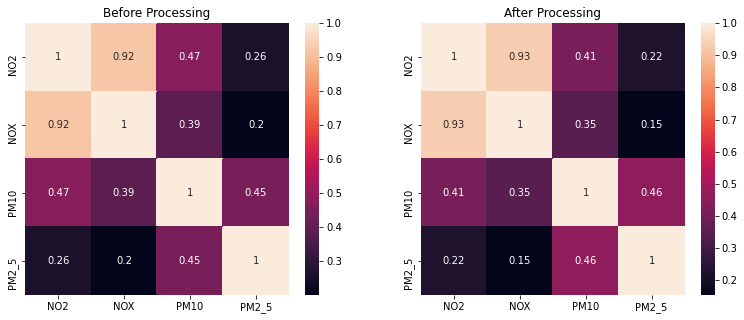

In [12]:
fig , ax =plt.subplots(1,2,figsize=(13,5))
ax[0].set_title("Before Processing")
ax[1].set_title("After Processing")
sns.heatmap(processedAQD.corr(), annot=True,ax= ax[1])
sns.heatmap(airQualityData[['NO2','NOX','PM10','PM2_5']].corr(), annot=True,ax= ax[0])

<AxesSubplot:xlabel='Start', ylabel='PM10'>

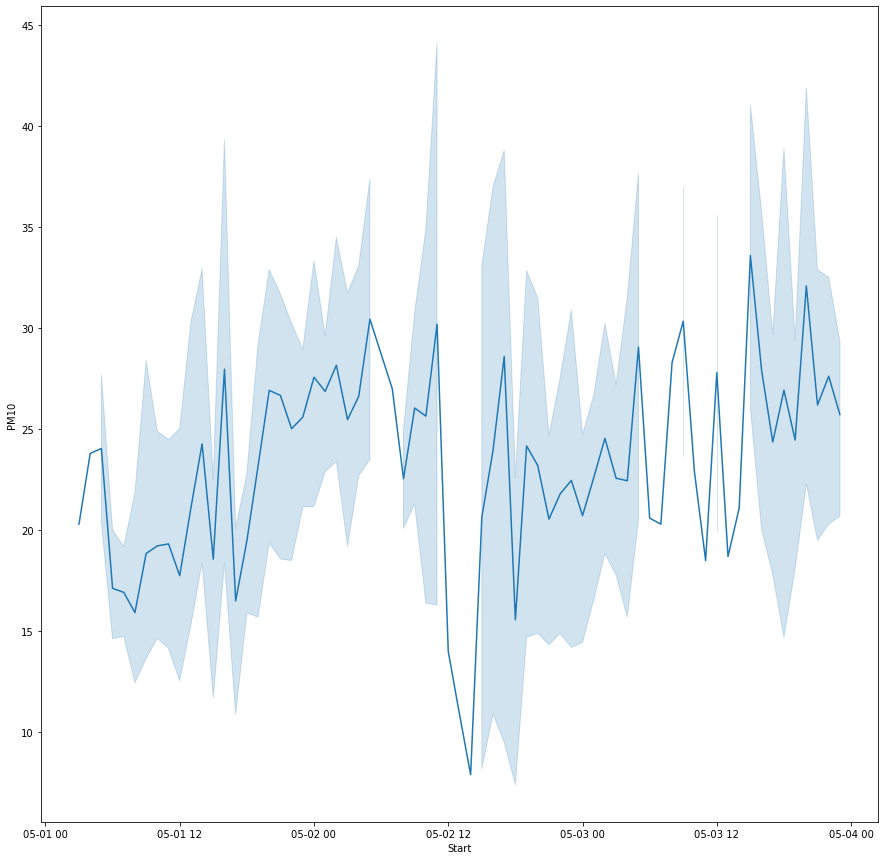

In [13]:
subsetData2 = processedAQD[(processedAQD['Start'] >"2016-05-01 00:00:00") & (processedAQD['Start'] < "2016-05-04 00:00:00")]
fig , ax =  plt.subplots(figsize=(15,15))
sns.lineplot(data=subsetData2,x="Start",y="PM10",ax=ax)

# LSTM

In [14]:
processedAQD.iloc[:800, 1:2]

,NO2
0,36.1
1,38.8
2,25.9
3,20.2
4,16.9
...,...
795,29.8
796,21.8
797,18.0
798,15.1
